# 🌱 Pivotal Future - recruitment task

This assignment is to test both your python and ML skills, and your ability to think critically about a
problem. A set of tasks is given below. Please summarise your findings in a short report (see instructions in the last section), and attach any code you use in your analysis. 

Do not spend more than 8 hours on the task. Read carefully all the sections, and then complete as you many sections as you wish.

You can either run the code locally on your machine, or use https://colab.google/ if you need GPU resources.

### 🌼 Background 
At Pivotal, we leverage AI for biodiversity measurement and monitoring. *Plants* are fundamental to ecosystems, serving as primary producers that support all life forms. Monitoring plant species and their distributions provides critical insights into ecosystem health, climate change effects, and biodiversity patterns. Accurate identification of plant species is essential for effective conservation efforts. However, plant identification presents challenges due to high variability in morphology, seasonal changes, and environmental influences. Leaves, flowers, bark, and growth patterns can vary significantly within species, making classification complex. 

You can read more about plants on the [iNaturalist page](https://www.inaturalist.org/taxa/47126-Plantae). You can explore identification techniques under the Observations section.

### 🖊️ The task
In this task, you will train and test a single-label classifier to distinguish between different species of plants, utilizing machine learning techniques to analyze and interpret the data.

The task is divided in the following parts:
1. Load and explore the dataset
2. Train the classification model
3. Evaluate the model
4. Bonus part (not mandatory)
5. Questions for report

We reccomend to read every section first, and then to start coding.

# 1. Data exploration

Download the dataset that was sent to you. This will contain the dataset needed for the task. It will be divided in 10 folders, each one containing the plant species indicated by the folder names. These will be your target classes.

In this section of the task, you have to: 
* inspect the dataset and make exploratory plots. Feel free to use the libraries that you prefer. 
* format the data so that you can use it for model training (i.e. folder structure, image sizes, etc...)




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from forestid.imagehandler import ImageHandler
from forestid import ROOT_PATH

In [3]:
image_path = os.path.join(ROOT_PATH, "data/plant_vision_dataset")

In [4]:
## Create dataframe with paths to original images and respective class
image_handler = ImageHandler()
image_df = image_handler.data_folders_to_df(image_path)
image_df.columns

Index(['image_path', 'image_id', 'species'], dtype='object')

In [5]:
## Verify that there are no repeated IDs between different classes
assert len(image_df["image_id"].unique())==len(image_df)

In [6]:
## Get total number of images
f"# Images: {len(image_df)}"

'# Images: 424'

In [7]:
## Verify data distribution between classes
image_df[["species","image_id"]].groupby("species").count()

image_id
species                         
Acis autumnalis               50
Adenocarpus telonensis         8
Amaranthus viridis            38
Anthemis arvensis             50
Anthemis maritima             50
Echium rosulatum              50
Geranium columbinum           50
Plantago coronopus            50
Rumex bucephalophorus         50
Triticum aestivum             28

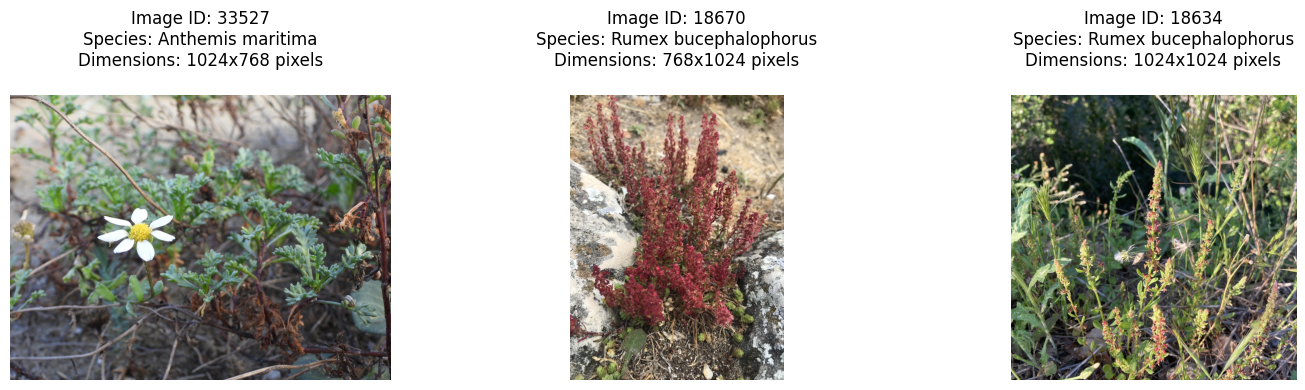

In [8]:
# Looking at the images themselves
from forestid.imageviewer import plot_random_images

plot_random_images(image_df,3)

In [9]:
# Analysing size and intensity distribution
from forestid.imageviewer import plot_metadata_distribution

image_df = image_handler.analyze_image_metadata(image_df)

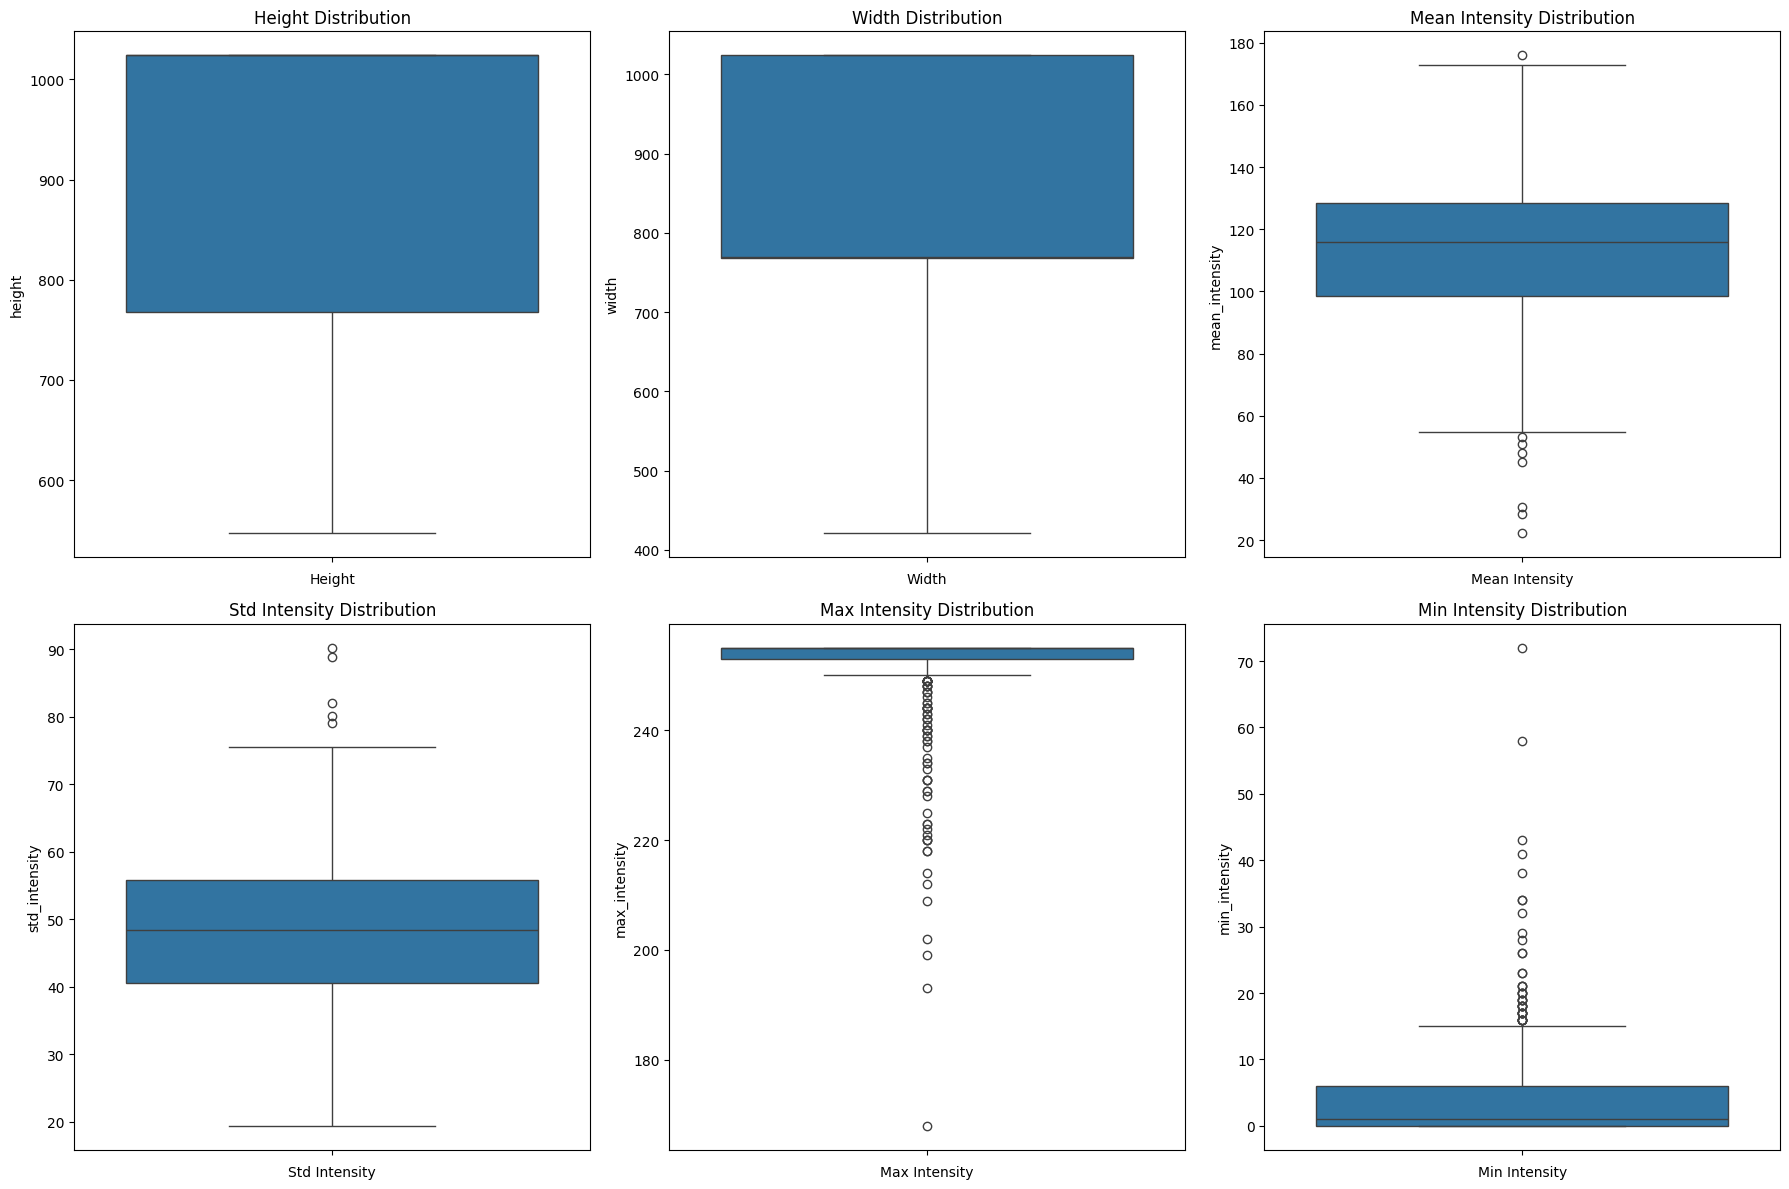

In [10]:
plot_metadata_distribution(image_df)

In [11]:
## Define minimum image size available and most common aspect ratio
f"""Min Height: {image_df['height'].min()}, Min Width: {image_df['width'].min()},
Average Aspect Ratio: {(image_df['height']/image_df['width']).mean()}"""

'Min Height: 547, Min Width: 421,\nAverage Aspect Ratio: 1.1042497569127208'

## 2. Train model

In this section you have to write the code to train a categorical classifier. The target classes are the species of the plants. You are free to use any library you prefer (i.e. tensorflow, pytorch, ...). 

We suggest you to use a simple solution, like a simple convolutional neural network (CNN), or a pretrained model using transfer learning techniques.

In [12]:
# The first naive experiment to define baseline results
experiment_id="baseline"

In [13]:
from forestid.datasethandler import PlantDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import json

In [14]:
# Split indices into train, validation, and test sets while maintaining the class proportions
train_indices, temp_indices = train_test_split(
    list(range(len(image_df))),
    stratify=image_df["species"],
    test_size=0.3,  # 30% goes to validation + test
    random_state=42
)

val_indices, test_indices = train_test_split(
    temp_indices,
    stratify=[image_df["species"][i] for i in temp_indices],
    test_size=0.5,  # 50% of the 30% goes to validation and 50% to test
    random_state=42
)
data_splits_df={'train': list(train_indices), 
             'val': list(val_indices), 
             'test': list(test_indices)}

with open(ROOT_PATH+"/data/dataset_splits.json", "w") as f:
    json.dump(data_splits_df, f)

In [14]:
import json
## Or alternatively load them from a file
with open(ROOT_PATH+"/data/dataset_splits.json", "r") as f:
    split_indices = json.load(f)

# Convert back to integer lists (in case they are stored as strings)
train_indices = [int(i) for i in split_indices["train"]]
val_indices = [int(i) for i in split_indices["val"]]
test_indices = [int(i) for i in split_indices["test"]]

In [16]:
train_dataset = PlantDataset(image_df["image_path"].iloc[train_indices].values, 
                             image_df["species"].iloc[train_indices].values,
                             classes_names=image_df["species"].unique(),
                             output_size=(224,224),
                             augment=False)

val_dataset = PlantDataset(image_df["image_path"].iloc[val_indices].values, 
                             image_df["species"].iloc[val_indices].values,
                            classes_names=image_df["species"].unique(),
                             output_size=(224,224),
                             augment=False)

test_dataset = PlantDataset(image_df["image_path"].iloc[test_indices].values, 
                             image_df["species"].iloc[test_indices].values,
                             classes_names=image_df["species"].unique(),
                             output_size=(224,224),
                             augment=False)


In [17]:
train_dataset.save_class_mapping(ROOT_PATH+'/model/class_mapping.json')

In [18]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [22]:
from forestid.modelhandler import ModelHandler
model_handler=ModelHandler()

In [19]:
model = model_handler.create_model(num_classes=len(image_df["species"].unique()))

Using cache found in /home/lulu/.cache/torch/hub/facebookresearch_dinov2_main
/home/lulu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lulu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lulu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [20]:
save_path = f"{ROOT_PATH}/model/{experiment_id}_best_model.pth"
train_loss, validation_loss = model_handler.train(model, 
                                                  train_loader,
                                                  val_loader, 
                                                  50,
                                                  lr=1e-5,
                                                  save_path=save_path)

Epoch 1/50:   0%|          | 0/37 [00:00<?, ?it/s]

/home/lulu/.conda/envs/forestid_venv_dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/50: 100%|██████████| 37/37 [00:24<00:00,  1.54it/s, loss=1.91]


✅ New best model saved at epoch 1 with Val Loss: 1.4727
Epoch 1/50 - Train Loss: 1.8586 - Val Loss: 1.4727 - Val Accuracy: 87.50%


Epoch 2/50: 100%|██████████| 37/37 [00:24<00:00,  1.54it/s, loss=1.06]


✅ New best model saved at epoch 2 with Val Loss: 0.8405
Epoch 2/50 - Train Loss: 1.0292 - Val Loss: 0.8405 - Val Accuracy: 93.75%


Epoch 3/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.506]


✅ New best model saved at epoch 3 with Val Loss: 0.5234
Epoch 3/50 - Train Loss: 0.4927 - Val Loss: 0.5234 - Val Accuracy: 93.75%


Epoch 4/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.253]


✅ New best model saved at epoch 4 with Val Loss: 0.3834
Epoch 4/50 - Train Loss: 0.2461 - Val Loss: 0.3834 - Val Accuracy: 95.31%


Epoch 5/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.148]


✅ New best model saved at epoch 5 with Val Loss: 0.2873
Epoch 5/50 - Train Loss: 0.1445 - Val Loss: 0.2873 - Val Accuracy: 98.44%


Epoch 6/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.101]


✅ New best model saved at epoch 6 with Val Loss: 0.2669
Epoch 6/50 - Train Loss: 0.0985 - Val Loss: 0.2669 - Val Accuracy: 95.31%


Epoch 7/50: 100%|██████████| 37/37 [00:24<00:00,  1.54it/s, loss=0.0677]


✅ New best model saved at epoch 7 with Val Loss: 0.2386
Epoch 7/50 - Train Loss: 0.0659 - Val Loss: 0.2386 - Val Accuracy: 93.75%


Epoch 8/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0552]


✅ New best model saved at epoch 8 with Val Loss: 0.2270
Epoch 8/50 - Train Loss: 0.0538 - Val Loss: 0.2270 - Val Accuracy: 93.75%


Epoch 9/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0427]


✅ New best model saved at epoch 9 with Val Loss: 0.2010
Epoch 9/50 - Train Loss: 0.0416 - Val Loss: 0.2010 - Val Accuracy: 93.75%


Epoch 10/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0328]


✅ New best model saved at epoch 10 with Val Loss: 0.1970
Epoch 10/50 - Train Loss: 0.0319 - Val Loss: 0.1970 - Val Accuracy: 96.88%


Epoch 11/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0273]


✅ New best model saved at epoch 11 with Val Loss: 0.1930
Epoch 11/50 - Train Loss: 0.0266 - Val Loss: 0.1930 - Val Accuracy: 95.31%


Epoch 12/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0247]


⚠️ Early stopping counter: 1/10
Epoch 12/50 - Train Loss: 0.0240 - Val Loss: 0.1934 - Val Accuracy: 93.75%


Epoch 13/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0202]


✅ New best model saved at epoch 13 with Val Loss: 0.1889
Epoch 13/50 - Train Loss: 0.0197 - Val Loss: 0.1889 - Val Accuracy: 95.31%


Epoch 14/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0181]


✅ New best model saved at epoch 14 with Val Loss: 0.1780
Epoch 14/50 - Train Loss: 0.0176 - Val Loss: 0.1780 - Val Accuracy: 93.75%


Epoch 15/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0152]


⚠️ Early stopping counter: 1/10
Epoch 15/50 - Train Loss: 0.0148 - Val Loss: 0.1817 - Val Accuracy: 95.31%


Epoch 16/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0143]


⚠️ Early stopping counter: 2/10
Epoch 16/50 - Train Loss: 0.0139 - Val Loss: 0.1793 - Val Accuracy: 93.75%


Epoch 17/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0133]


⚠️ Early stopping counter: 3/10
Epoch 17/50 - Train Loss: 0.0129 - Val Loss: 0.1928 - Val Accuracy: 93.75%


Epoch 18/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0119]


⚠️ Early stopping counter: 4/10
Epoch 18/50 - Train Loss: 0.0115 - Val Loss: 0.1854 - Val Accuracy: 93.75%


Epoch 19/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0107]


⚠️ Early stopping counter: 5/10
Epoch 19/50 - Train Loss: 0.0104 - Val Loss: 0.1854 - Val Accuracy: 93.75%


Epoch 20/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00977]


⚠️ Early stopping counter: 6/10
Epoch 20/50 - Train Loss: 0.0095 - Val Loss: 0.1882 - Val Accuracy: 92.19%


Epoch 21/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00895]


⚠️ Early stopping counter: 7/10
Epoch 21/50 - Train Loss: 0.0087 - Val Loss: 0.1856 - Val Accuracy: 93.75%


Epoch 22/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00843]


⚠️ Early stopping counter: 8/10
Epoch 22/50 - Train Loss: 0.0082 - Val Loss: 0.1859 - Val Accuracy: 93.75%


Epoch 23/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00785]


⚠️ Early stopping counter: 9/10
Epoch 23/50 - Train Loss: 0.0076 - Val Loss: 0.1828 - Val Accuracy: 93.75%


Epoch 24/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00706]


⚠️ Early stopping counter: 10/10
Epoch 24/50 - Train Loss: 0.0069 - Val Loss: 0.1841 - Val Accuracy: 93.75%
⏹️ Early stopping triggered. Training stopped.
Training complete.


## 3. Inference and metrics

Visualize the training and validation loss and accuracy to analyze the performance. Make some plots to show the performance of the model (i.e. confusion matrix, ROC curve, ...)


In [29]:
base_eval_df = image_df[["image_path","image_id","species"]].iloc[test_indices]
base_eval_df=base_eval_df.rename(columns={"species":"gt"})

In [22]:
# To save all experiment metrics and compare
exp_eval_df = []

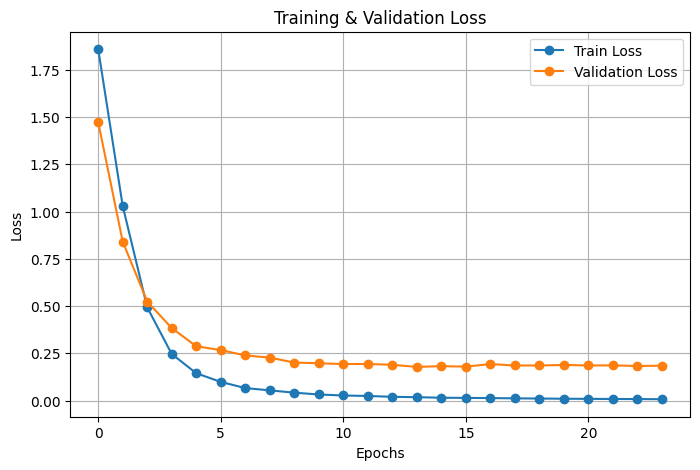

In [23]:
from forestid.imageviewer import plot_train_losses

plot_train_losses(train_loss, validation_loss)

In [24]:
predictions,probabilities = model_handler.test(model,test_loader)

In [25]:
class_predictions = [test_dataset.get_class_name(pred) for pred in predictions]

In [26]:
eval_df = base_eval_df.copy()
eval_df["model"] = experiment_id
eval_df["prediction"] = class_predictions
eval_df["probabilities"] = probabilities
exp_eval_df.append(eval_df)

In [40]:
from forestid.evaluator import calculate_metrics

rep,matrix = calculate_metrics(eval_df)
print(rep)

                        precision    recall  f1-score   support

       Acis autumnalis       1.00      1.00      1.00         7
Adenocarpus telonensis       1.00      1.00      1.00         1
    Amaranthus viridis       1.00      1.00      1.00         6
     Anthemis arvensis       0.88      1.00      0.93         7
     Anthemis maritima       1.00      1.00      1.00         8
      Echium rosulatum       1.00      1.00      1.00         8
   Geranium columbinum       1.00      1.00      1.00         8
    Plantago coronopus       0.88      1.00      0.93         7
 Rumex bucephalophorus       1.00      1.00      1.00         8
     Triticum aestivum       1.00      0.50      0.67         4

              accuracy                           0.97        64
             macro avg       0.97      0.95      0.95        64
          weighted avg       0.97      0.97      0.96        64



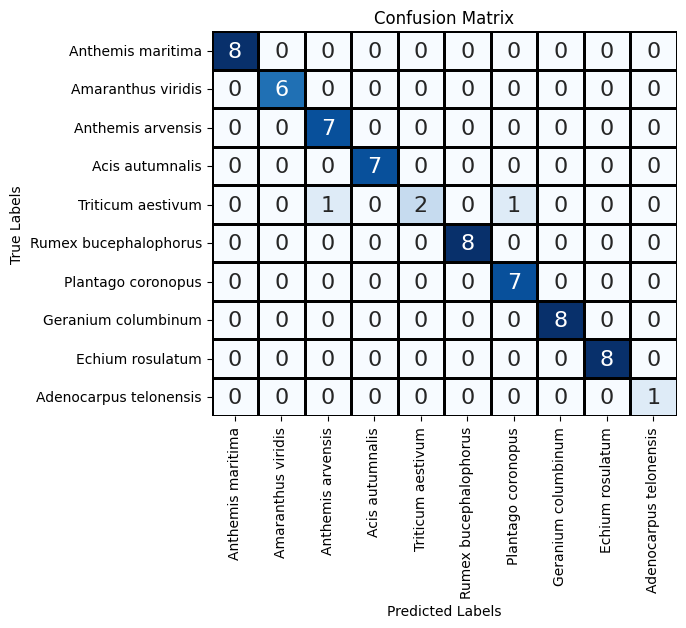

In [42]:
from forestid.imageviewer import plot_random_predictions, plot_confusion_matrix
plot_confusion_matrix(eval_df,matrix)


2 1


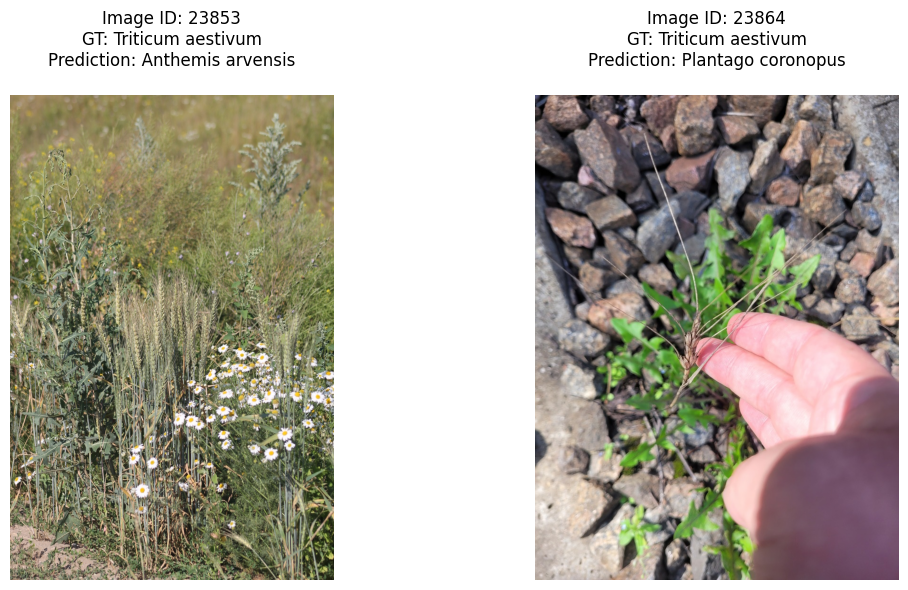

In [46]:
plot_random_predictions(eval_df,missclassified=True)

## 4. Bonus part (not mandatory)

In this section, you can be creative and add extra parts that are not requested in the task. Possible additions could be (but are not limited to): 
* testing effect of data augmentations 
* compare different model architectures performance
* use the features extracted by the CNN model to cluster different predictions using k-means 

### Experience: Apply data augmentation

In [48]:
experiment_id="augmentation"

In [24]:
train_dataset = PlantDataset(image_df["image_path"].iloc[train_indices].values, 
                             image_df["species"].iloc[train_indices].values,
                             classes_names=image_df["species"].unique(),
                             output_size=(224,224),
                             augment=True)

In [19]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Get class distribution
labels = [label for _, label in train_dataset]  # Assuming dataset returns (image, label)
class_counts = np.bincount(labels)  # Count occurrences per class
class_weights = 1.0 / class_counts  # Inverse of frequency

# Assign weights to each sample
sample_weights = [class_weights[label] for label in labels]

# Create a sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(labels), replacement=True)


In [52]:
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)

In [56]:
model = model_handler.create_model(num_classes=len(image_df["species"].unique()))
save_path = f"{ROOT_PATH}/model/{experiment_id}_best_model.pth"
train_loss, validation_loss = model_handler.train(model, 
                                                  train_loader,
                                                  val_loader, 
                                                  50,
                                                  lr=1e-5,
                                                  save_path=save_path)

Using cache found in /home/lulu/.cache/torch/hub/facebookresearch_dinov2_main
Epoch 1/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=1.88]


✅ New best model saved at epoch 1 with Val Loss: 1.4717
Epoch 1/50 - Train Loss: 1.8282 - Val Loss: 1.4717 - Val Accuracy: 85.94%


Epoch 2/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=1.08]


✅ New best model saved at epoch 2 with Val Loss: 0.8664
Epoch 2/50 - Train Loss: 1.0484 - Val Loss: 0.8664 - Val Accuracy: 84.38%


Epoch 3/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.554]


✅ New best model saved at epoch 3 with Val Loss: 0.5735
Epoch 3/50 - Train Loss: 0.5399 - Val Loss: 0.5735 - Val Accuracy: 90.62%


Epoch 4/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.307]


✅ New best model saved at epoch 4 with Val Loss: 0.3789
Epoch 4/50 - Train Loss: 0.2990 - Val Loss: 0.3789 - Val Accuracy: 96.88%


Epoch 5/50: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s, loss=0.212]


✅ New best model saved at epoch 5 with Val Loss: 0.2848
Epoch 5/50 - Train Loss: 0.2067 - Val Loss: 0.2848 - Val Accuracy: 98.44%


Epoch 6/50: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s, loss=0.131]


✅ New best model saved at epoch 6 with Val Loss: 0.2798
Epoch 6/50 - Train Loss: 0.1277 - Val Loss: 0.2798 - Val Accuracy: 95.31%


Epoch 7/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.105]


✅ New best model saved at epoch 7 with Val Loss: 0.1778
Epoch 7/50 - Train Loss: 0.1026 - Val Loss: 0.1778 - Val Accuracy: 98.44%


Epoch 8/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.067] 


✅ New best model saved at epoch 8 with Val Loss: 0.1461
Epoch 8/50 - Train Loss: 0.0653 - Val Loss: 0.1461 - Val Accuracy: 98.44%


Epoch 9/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0901]


⚠️ Early stopping counter: 1/10
Epoch 9/50 - Train Loss: 0.0877 - Val Loss: 0.2039 - Val Accuracy: 96.88%


Epoch 10/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.084] 


⚠️ Early stopping counter: 2/10
Epoch 10/50 - Train Loss: 0.0818 - Val Loss: 0.1888 - Val Accuracy: 96.88%


Epoch 11/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0451]


⚠️ Early stopping counter: 3/10
Epoch 11/50 - Train Loss: 0.0439 - Val Loss: 0.2058 - Val Accuracy: 95.31%


Epoch 12/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0393]


⚠️ Early stopping counter: 4/10
Epoch 12/50 - Train Loss: 0.0383 - Val Loss: 0.1581 - Val Accuracy: 95.31%


Epoch 13/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0365]


✅ New best model saved at epoch 13 with Val Loss: 0.1099
Epoch 13/50 - Train Loss: 0.0355 - Val Loss: 0.1099 - Val Accuracy: 98.44%


Epoch 14/50: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s, loss=0.0241]


✅ New best model saved at epoch 14 with Val Loss: 0.1000
Epoch 14/50 - Train Loss: 0.0235 - Val Loss: 0.1000 - Val Accuracy: 98.44%


Epoch 15/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0235]


⚠️ Early stopping counter: 1/10
Epoch 15/50 - Train Loss: 0.0228 - Val Loss: 0.4496 - Val Accuracy: 87.50%


Epoch 16/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0329]


✅ New best model saved at epoch 16 with Val Loss: 0.0958
Epoch 16/50 - Train Loss: 0.0320 - Val Loss: 0.0958 - Val Accuracy: 98.44%


Epoch 17/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0194]


✅ New best model saved at epoch 17 with Val Loss: 0.0928
Epoch 17/50 - Train Loss: 0.0189 - Val Loss: 0.0928 - Val Accuracy: 98.44%


Epoch 18/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0178]


✅ New best model saved at epoch 18 with Val Loss: 0.0854
Epoch 18/50 - Train Loss: 0.0174 - Val Loss: 0.0854 - Val Accuracy: 98.44%


Epoch 19/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0139]


✅ New best model saved at epoch 19 with Val Loss: 0.0809
Epoch 19/50 - Train Loss: 0.0135 - Val Loss: 0.0809 - Val Accuracy: 98.44%


Epoch 20/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0129]


✅ New best model saved at epoch 20 with Val Loss: 0.0790
Epoch 20/50 - Train Loss: 0.0125 - Val Loss: 0.0790 - Val Accuracy: 98.44%


Epoch 21/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0121]


✅ New best model saved at epoch 21 with Val Loss: 0.0788
Epoch 21/50 - Train Loss: 0.0118 - Val Loss: 0.0788 - Val Accuracy: 98.44%


Epoch 22/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0108]


✅ New best model saved at epoch 22 with Val Loss: 0.0769
Epoch 22/50 - Train Loss: 0.0105 - Val Loss: 0.0769 - Val Accuracy: 98.44%


Epoch 23/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00984]


✅ New best model saved at epoch 23 with Val Loss: 0.0744
Epoch 23/50 - Train Loss: 0.0096 - Val Loss: 0.0744 - Val Accuracy: 98.44%


Epoch 24/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00941]


⚠️ Early stopping counter: 1/10
Epoch 24/50 - Train Loss: 0.0092 - Val Loss: 0.0754 - Val Accuracy: 98.44%


Epoch 25/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00949]


✅ New best model saved at epoch 25 with Val Loss: 0.0734
Epoch 25/50 - Train Loss: 0.0092 - Val Loss: 0.0734 - Val Accuracy: 98.44%


Epoch 26/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.0079] 


✅ New best model saved at epoch 26 with Val Loss: 0.0729
Epoch 26/50 - Train Loss: 0.0077 - Val Loss: 0.0729 - Val Accuracy: 98.44%


Epoch 27/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00721]


⚠️ Early stopping counter: 1/10
Epoch 27/50 - Train Loss: 0.0070 - Val Loss: 0.0736 - Val Accuracy: 98.44%


Epoch 28/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00727]


✅ New best model saved at epoch 28 with Val Loss: 0.0709
Epoch 28/50 - Train Loss: 0.0071 - Val Loss: 0.0709 - Val Accuracy: 98.44%


Epoch 29/50: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s, loss=0.00712]


✅ New best model saved at epoch 29 with Val Loss: 0.0680
Epoch 29/50 - Train Loss: 0.0069 - Val Loss: 0.0680 - Val Accuracy: 98.44%


Epoch 30/50: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s, loss=0.00654]


✅ New best model saved at epoch 30 with Val Loss: 0.0677
Epoch 30/50 - Train Loss: 0.0064 - Val Loss: 0.0677 - Val Accuracy: 98.44%


Epoch 31/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00634]


⚠️ Early stopping counter: 1/10
Epoch 31/50 - Train Loss: 0.0062 - Val Loss: 0.0688 - Val Accuracy: 98.44%


Epoch 32/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00573]


⚠️ Early stopping counter: 2/10
Epoch 32/50 - Train Loss: 0.0056 - Val Loss: 0.0678 - Val Accuracy: 98.44%


Epoch 33/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00613]


⚠️ Early stopping counter: 3/10
Epoch 33/50 - Train Loss: 0.0060 - Val Loss: 0.0710 - Val Accuracy: 98.44%


Epoch 34/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00515]


✅ New best model saved at epoch 34 with Val Loss: 0.0677
Epoch 34/50 - Train Loss: 0.0050 - Val Loss: 0.0677 - Val Accuracy: 98.44%


Epoch 35/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00461]


✅ New best model saved at epoch 35 with Val Loss: 0.0654
Epoch 35/50 - Train Loss: 0.0045 - Val Loss: 0.0654 - Val Accuracy: 98.44%


Epoch 36/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.0045] 


✅ New best model saved at epoch 36 with Val Loss: 0.0637
Epoch 36/50 - Train Loss: 0.0044 - Val Loss: 0.0637 - Val Accuracy: 98.44%


Epoch 37/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00463]


⚠️ Early stopping counter: 1/10
Epoch 37/50 - Train Loss: 0.0045 - Val Loss: 0.0644 - Val Accuracy: 98.44%


Epoch 38/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00418]


✅ New best model saved at epoch 38 with Val Loss: 0.0632
Epoch 38/50 - Train Loss: 0.0041 - Val Loss: 0.0632 - Val Accuracy: 98.44%


Epoch 39/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00405]


⚠️ Early stopping counter: 1/10
Epoch 39/50 - Train Loss: 0.0039 - Val Loss: 0.0648 - Val Accuracy: 98.44%


Epoch 40/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00359]


✅ New best model saved at epoch 40 with Val Loss: 0.0627
Epoch 40/50 - Train Loss: 0.0035 - Val Loss: 0.0627 - Val Accuracy: 98.44%


Epoch 41/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00371]


✅ New best model saved at epoch 41 with Val Loss: 0.0624
Epoch 41/50 - Train Loss: 0.0036 - Val Loss: 0.0624 - Val Accuracy: 98.44%


Epoch 42/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00377]


✅ New best model saved at epoch 42 with Val Loss: 0.0592
Epoch 42/50 - Train Loss: 0.0037 - Val Loss: 0.0592 - Val Accuracy: 98.44%


Epoch 43/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00346]


⚠️ Early stopping counter: 1/10
Epoch 43/50 - Train Loss: 0.0034 - Val Loss: 0.0595 - Val Accuracy: 98.44%


Epoch 44/50: 100%|██████████| 37/37 [00:26<00:00,  1.38it/s, loss=0.00319]


⚠️ Early stopping counter: 2/10
Epoch 44/50 - Train Loss: 0.0031 - Val Loss: 0.0600 - Val Accuracy: 98.44%


Epoch 45/50: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s, loss=0.00316]


⚠️ Early stopping counter: 3/10
Epoch 45/50 - Train Loss: 0.0031 - Val Loss: 0.0598 - Val Accuracy: 98.44%


Epoch 46/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00277]


⚠️ Early stopping counter: 4/10
Epoch 46/50 - Train Loss: 0.0027 - Val Loss: 0.0617 - Val Accuracy: 98.44%


Epoch 47/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00289]


⚠️ Early stopping counter: 5/10
Epoch 47/50 - Train Loss: 0.0028 - Val Loss: 0.0604 - Val Accuracy: 98.44%


Epoch 48/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00283]


✅ New best model saved at epoch 48 with Val Loss: 0.0591
Epoch 48/50 - Train Loss: 0.0028 - Val Loss: 0.0591 - Val Accuracy: 98.44%


Epoch 49/50: 100%|██████████| 37/37 [00:26<00:00,  1.39it/s, loss=0.00249]


✅ New best model saved at epoch 49 with Val Loss: 0.0580
Epoch 49/50 - Train Loss: 0.0024 - Val Loss: 0.0580 - Val Accuracy: 98.44%


Epoch 50/50: 100%|██████████| 37/37 [00:26<00:00,  1.37it/s, loss=0.00245]


✅ New best model saved at epoch 50 with Val Loss: 0.0568
Epoch 50/50 - Train Loss: 0.0024 - Val Loss: 0.0568 - Val Accuracy: 98.44%
Training complete.


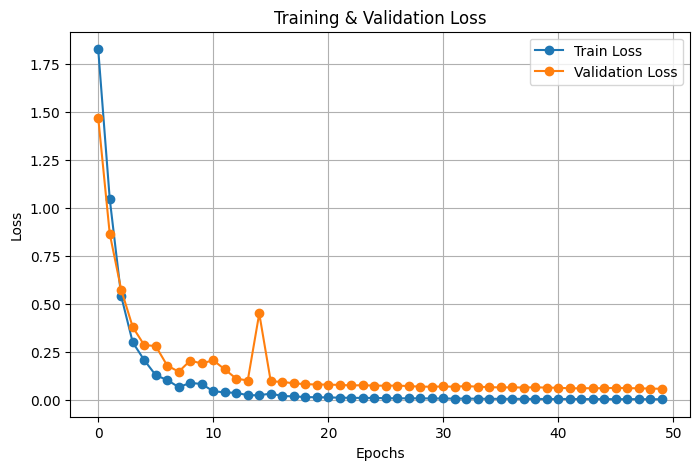

In [58]:
plot_train_losses(train_loss, validation_loss)

In [59]:
predictions,probabilities = model_handler.test(model,test_loader)

In [65]:
class_predictions = [test_dataset.get_class_name(pred) for pred in predictions]

In [66]:
eval_df = base_eval_df.copy()
eval_df["model"] = experiment_id
eval_df["prediction"] = class_predictions
eval_df["probabilities"] = probabilities
exp_eval_df.append(eval_df)

In [67]:
rep,matrix = calculate_metrics(eval_df)
print(rep)

                        precision    recall  f1-score   support

       Acis autumnalis       1.00      1.00      1.00         7
Adenocarpus telonensis       1.00      1.00      1.00         1
    Amaranthus viridis       1.00      1.00      1.00         6
     Anthemis arvensis       0.88      1.00      0.93         7
     Anthemis maritima       1.00      1.00      1.00         8
      Echium rosulatum       1.00      1.00      1.00         8
   Geranium columbinum       1.00      1.00      1.00         8
    Plantago coronopus       1.00      1.00      1.00         7
 Rumex bucephalophorus       1.00      1.00      1.00         8
     Triticum aestivum       1.00      0.75      0.86         4

              accuracy                           0.98        64
             macro avg       0.99      0.97      0.98        64
          weighted avg       0.99      0.98      0.98        64



1 1


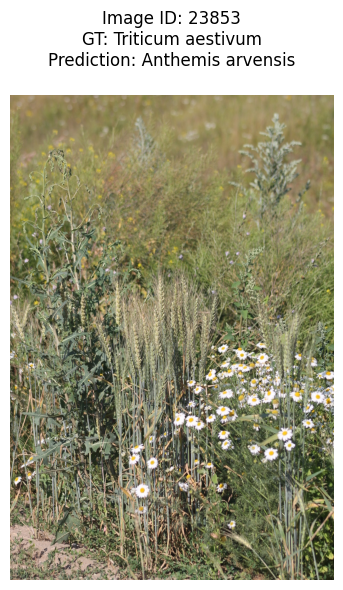

In [68]:
plot_random_predictions(eval_df,missclassified=True)

### Experience: Apply weighted loss during training

In [36]:
experiment_id="weighted_loss"

In [37]:
train_dataset = PlantDataset(image_df["image_path"].iloc[train_indices].values, 
                             image_df["species"].iloc[train_indices].values,
                             classes_names=image_df["species"].unique(),
                             output_size=(224,224),
                             augment=False)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=8)

In [39]:
import numpy as np
from torch import Tensor

model = model_handler.create_model(num_classes=len(image_df["species"].unique()))
save_path = f"{ROOT_PATH}/model/{experiment_id}_best_model.pth"
train_loss, validation_loss = model_handler.train(model, 
                                                  train_loader,
                                                  val_loader, 
                                                  50,
                                                  class_weights=Tensor(class_weights),
                                                  lr=1e-5,
                                                  save_path=save_path)

Using cache found in /home/lulu/.cache/torch/hub/facebookresearch_dinov2_main
Epoch 1/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=1.9] 


✅ New best model saved at epoch 1 with Val Loss: 1.4889
Epoch 1/50 - Train Loss: 1.8457 - Val Loss: 1.4889 - Val Accuracy: 89.06%


Epoch 2/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=1.1] 


✅ New best model saved at epoch 2 with Val Loss: 0.9079
Epoch 2/50 - Train Loss: 1.0705 - Val Loss: 0.9079 - Val Accuracy: 90.62%


Epoch 3/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.569]


✅ New best model saved at epoch 3 with Val Loss: 0.5594
Epoch 3/50 - Train Loss: 0.5542 - Val Loss: 0.5594 - Val Accuracy: 93.75%


Epoch 4/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.299]


✅ New best model saved at epoch 4 with Val Loss: 0.4047
Epoch 4/50 - Train Loss: 0.2915 - Val Loss: 0.4047 - Val Accuracy: 96.88%


Epoch 5/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.167]


✅ New best model saved at epoch 5 with Val Loss: 0.3043
Epoch 5/50 - Train Loss: 0.1622 - Val Loss: 0.3043 - Val Accuracy: 95.31%


Epoch 6/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.105]


✅ New best model saved at epoch 6 with Val Loss: 0.2750
Epoch 6/50 - Train Loss: 0.1025 - Val Loss: 0.2750 - Val Accuracy: 96.88%


Epoch 7/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0769]


✅ New best model saved at epoch 7 with Val Loss: 0.2402
Epoch 7/50 - Train Loss: 0.0749 - Val Loss: 0.2402 - Val Accuracy: 95.31%


Epoch 8/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0607]


✅ New best model saved at epoch 8 with Val Loss: 0.2183
Epoch 8/50 - Train Loss: 0.0591 - Val Loss: 0.2183 - Val Accuracy: 95.31%


Epoch 9/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0468]


✅ New best model saved at epoch 9 with Val Loss: 0.2063
Epoch 9/50 - Train Loss: 0.0456 - Val Loss: 0.2063 - Val Accuracy: 95.31%


Epoch 10/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.039] 


✅ New best model saved at epoch 10 with Val Loss: 0.1896
Epoch 10/50 - Train Loss: 0.0380 - Val Loss: 0.1896 - Val Accuracy: 95.31%


Epoch 11/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.033] 


⚠️ Early stopping counter: 1/10
Epoch 11/50 - Train Loss: 0.0321 - Val Loss: 0.1964 - Val Accuracy: 95.31%


Epoch 12/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0258]


✅ New best model saved at epoch 12 with Val Loss: 0.1838
Epoch 12/50 - Train Loss: 0.0251 - Val Loss: 0.1838 - Val Accuracy: 95.31%


Epoch 13/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0224]


⚠️ Early stopping counter: 1/10
Epoch 13/50 - Train Loss: 0.0218 - Val Loss: 0.1878 - Val Accuracy: 95.31%


Epoch 14/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0207]


✅ New best model saved at epoch 14 with Val Loss: 0.1776
Epoch 14/50 - Train Loss: 0.0202 - Val Loss: 0.1776 - Val Accuracy: 95.31%


Epoch 15/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0183]


✅ New best model saved at epoch 15 with Val Loss: 0.1767
Epoch 15/50 - Train Loss: 0.0178 - Val Loss: 0.1767 - Val Accuracy: 95.31%


Epoch 16/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0163]


⚠️ Early stopping counter: 1/10
Epoch 16/50 - Train Loss: 0.0159 - Val Loss: 0.1797 - Val Accuracy: 95.31%


Epoch 17/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0141]


✅ New best model saved at epoch 17 with Val Loss: 0.1749
Epoch 17/50 - Train Loss: 0.0137 - Val Loss: 0.1749 - Val Accuracy: 95.31%


Epoch 18/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0135]


✅ New best model saved at epoch 18 with Val Loss: 0.1670
Epoch 18/50 - Train Loss: 0.0132 - Val Loss: 0.1670 - Val Accuracy: 95.31%


Epoch 19/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.012] 


⚠️ Early stopping counter: 1/10
Epoch 19/50 - Train Loss: 0.0117 - Val Loss: 0.1700 - Val Accuracy: 95.31%


Epoch 20/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0109]


⚠️ Early stopping counter: 2/10
Epoch 20/50 - Train Loss: 0.0106 - Val Loss: 0.1723 - Val Accuracy: 95.31%


Epoch 21/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.0103]


⚠️ Early stopping counter: 3/10
Epoch 21/50 - Train Loss: 0.0100 - Val Loss: 0.1713 - Val Accuracy: 95.31%


Epoch 22/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00925]


✅ New best model saved at epoch 22 with Val Loss: 0.1576
Epoch 22/50 - Train Loss: 0.0090 - Val Loss: 0.1576 - Val Accuracy: 95.31%


Epoch 23/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00961]


⚠️ Early stopping counter: 1/10
Epoch 23/50 - Train Loss: 0.0094 - Val Loss: 0.1757 - Val Accuracy: 95.31%


Epoch 24/50: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s, loss=0.00892]


⚠️ Early stopping counter: 2/10
Epoch 24/50 - Train Loss: 0.0087 - Val Loss: 0.1674 - Val Accuracy: 95.31%


Epoch 25/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00779]


⚠️ Early stopping counter: 3/10
Epoch 25/50 - Train Loss: 0.0076 - Val Loss: 0.1674 - Val Accuracy: 95.31%


Epoch 26/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00715]


⚠️ Early stopping counter: 4/10
Epoch 26/50 - Train Loss: 0.0070 - Val Loss: 0.1697 - Val Accuracy: 93.75%


Epoch 27/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00674]


⚠️ Early stopping counter: 5/10
Epoch 27/50 - Train Loss: 0.0066 - Val Loss: 0.1731 - Val Accuracy: 93.75%


Epoch 28/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00627]


⚠️ Early stopping counter: 6/10
Epoch 28/50 - Train Loss: 0.0061 - Val Loss: 0.1757 - Val Accuracy: 95.31%


Epoch 29/50: 100%|██████████| 37/37 [00:24<00:00,  1.53it/s, loss=0.00581]


⚠️ Early stopping counter: 7/10
Epoch 29/50 - Train Loss: 0.0057 - Val Loss: 0.1733 - Val Accuracy: 93.75%


Epoch 30/50: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s, loss=0.00578]


⚠️ Early stopping counter: 8/10
Epoch 30/50 - Train Loss: 0.0056 - Val Loss: 0.1591 - Val Accuracy: 93.75%


Epoch 31/50: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s, loss=0.00543]


⚠️ Early stopping counter: 9/10
Epoch 31/50 - Train Loss: 0.0053 - Val Loss: 0.1809 - Val Accuracy: 93.75%


Epoch 32/50: 100%|██████████| 37/37 [00:24<00:00,  1.52it/s, loss=0.00531]


⚠️ Early stopping counter: 10/10
Epoch 32/50 - Train Loss: 0.0052 - Val Loss: 0.1743 - Val Accuracy: 93.75%
⏹️ Early stopping triggered. Training stopped.
Training complete.


In [40]:
predictions,probabilities = model_handler.test(model,test_loader)

In [41]:
class_predictions = [test_dataset.get_class_name(pred) for pred in predictions]

In [42]:
eval_df = base_eval_df.copy()
eval_df["model"] = experiment_id
eval_df["prediction"] = class_predictions
eval_df["probabilities"] = probabilities
exp_eval_df.append(eval_df)

In [43]:
rep,matrix = calculate_metrics(eval_df)
print(rep)

                        precision    recall  f1-score   support

       Acis autumnalis       1.00      1.00      1.00         7
Adenocarpus telonensis       1.00      1.00      1.00         1
    Amaranthus viridis       1.00      1.00      1.00         6
     Anthemis arvensis       0.88      1.00      0.93         7
     Anthemis maritima       1.00      1.00      1.00         8
      Echium rosulatum       1.00      1.00      1.00         8
   Geranium columbinum       1.00      1.00      1.00         8
    Plantago coronopus       0.88      1.00      0.93         7
 Rumex bucephalophorus       1.00      1.00      1.00         8
     Triticum aestivum       1.00      0.50      0.67         4

              accuracy                           0.97        64
             macro avg       0.97      0.95      0.95        64
          weighted avg       0.97      0.97      0.96        64



### Experience: Use a smaller architecture

In [44]:
experiment_id="augmentation_smaller_model"

In [45]:
train_dataset = PlantDataset(image_df["image_path"].iloc[train_indices].values, 
                             image_df["species"].iloc[train_indices].values,
                             classes_names=image_df["species"].unique(),
                             output_size=(224,224),
                             augment=True)

In [46]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Get class distribution
labels = [label for _, label in train_dataset]  # Assuming dataset returns (image, label)
class_counts = np.bincount(labels)  # Count occurrences per class
class_weights = 1.0 / class_counts  # Inverse of frequency

# Assign weights to each sample
sample_weights = [class_weights[label] for label in labels]

# Create a sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(labels), replacement=True)


In [47]:
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)

In [ ]:
model = model_handler.create_model(num_classes=len(image_df["species"].unique()),
                                   backbone_model_name='dinov2_vits14_reg')
save_path = f"{ROOT_PATH}/model/{experiment_id}_best_model.pth"
train_loss, validation_loss = model_handler.train(model, 
                                                  train_loader,
                                                  val_loader, 
                                                  50,
                                                  lr=1e-5,
                                                  save_path=save_path)

In [49]:
predictions,probabilities = model_handler.test(model,test_loader)

In [50]:
class_predictions = [test_dataset.get_class_name(pred) for pred in predictions]

In [51]:
eval_df = base_eval_df.copy()
eval_df["model"] = experiment_id
eval_df["prediction"] = class_predictions
eval_df["probabilities"] = probabilities
exp_eval_df.append(eval_df)

In [52]:
rep,matrix = calculate_metrics(eval_df)
print(rep)

                        precision    recall  f1-score   support

       Acis autumnalis       1.00      1.00      1.00         7
Adenocarpus telonensis       1.00      1.00      1.00         1
    Amaranthus viridis       1.00      1.00      1.00         6
     Anthemis arvensis       0.78      1.00      0.88         7
     Anthemis maritima       1.00      0.88      0.93         8
      Echium rosulatum       0.89      1.00      0.94         8
   Geranium columbinum       1.00      0.75      0.86         8
    Plantago coronopus       0.88      1.00      0.93         7
 Rumex bucephalophorus       1.00      1.00      1.00         8
     Triticum aestivum       1.00      0.75      0.86         4

              accuracy                           0.94        64
             macro avg       0.95      0.94      0.94        64
          weighted avg       0.95      0.94      0.94        64



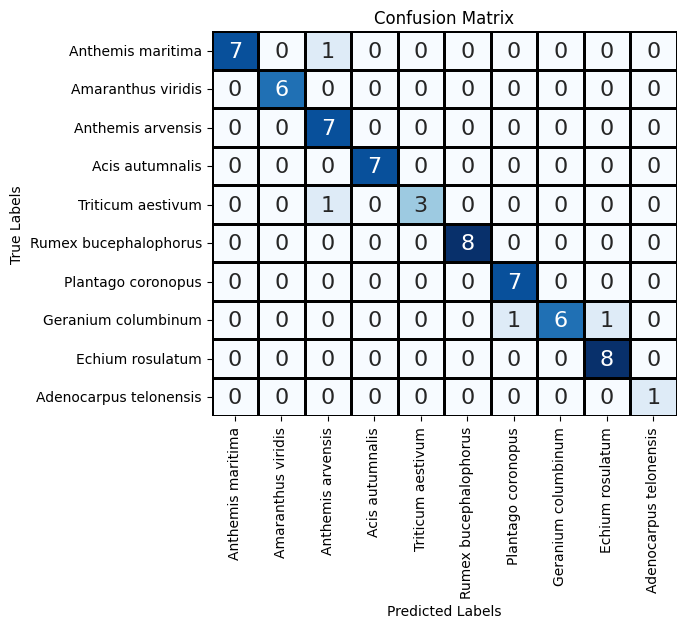

In [53]:
from forestid.imageviewer import plot_random_predictions, plot_confusion_matrix
plot_confusion_matrix(eval_df,matrix)

4 2


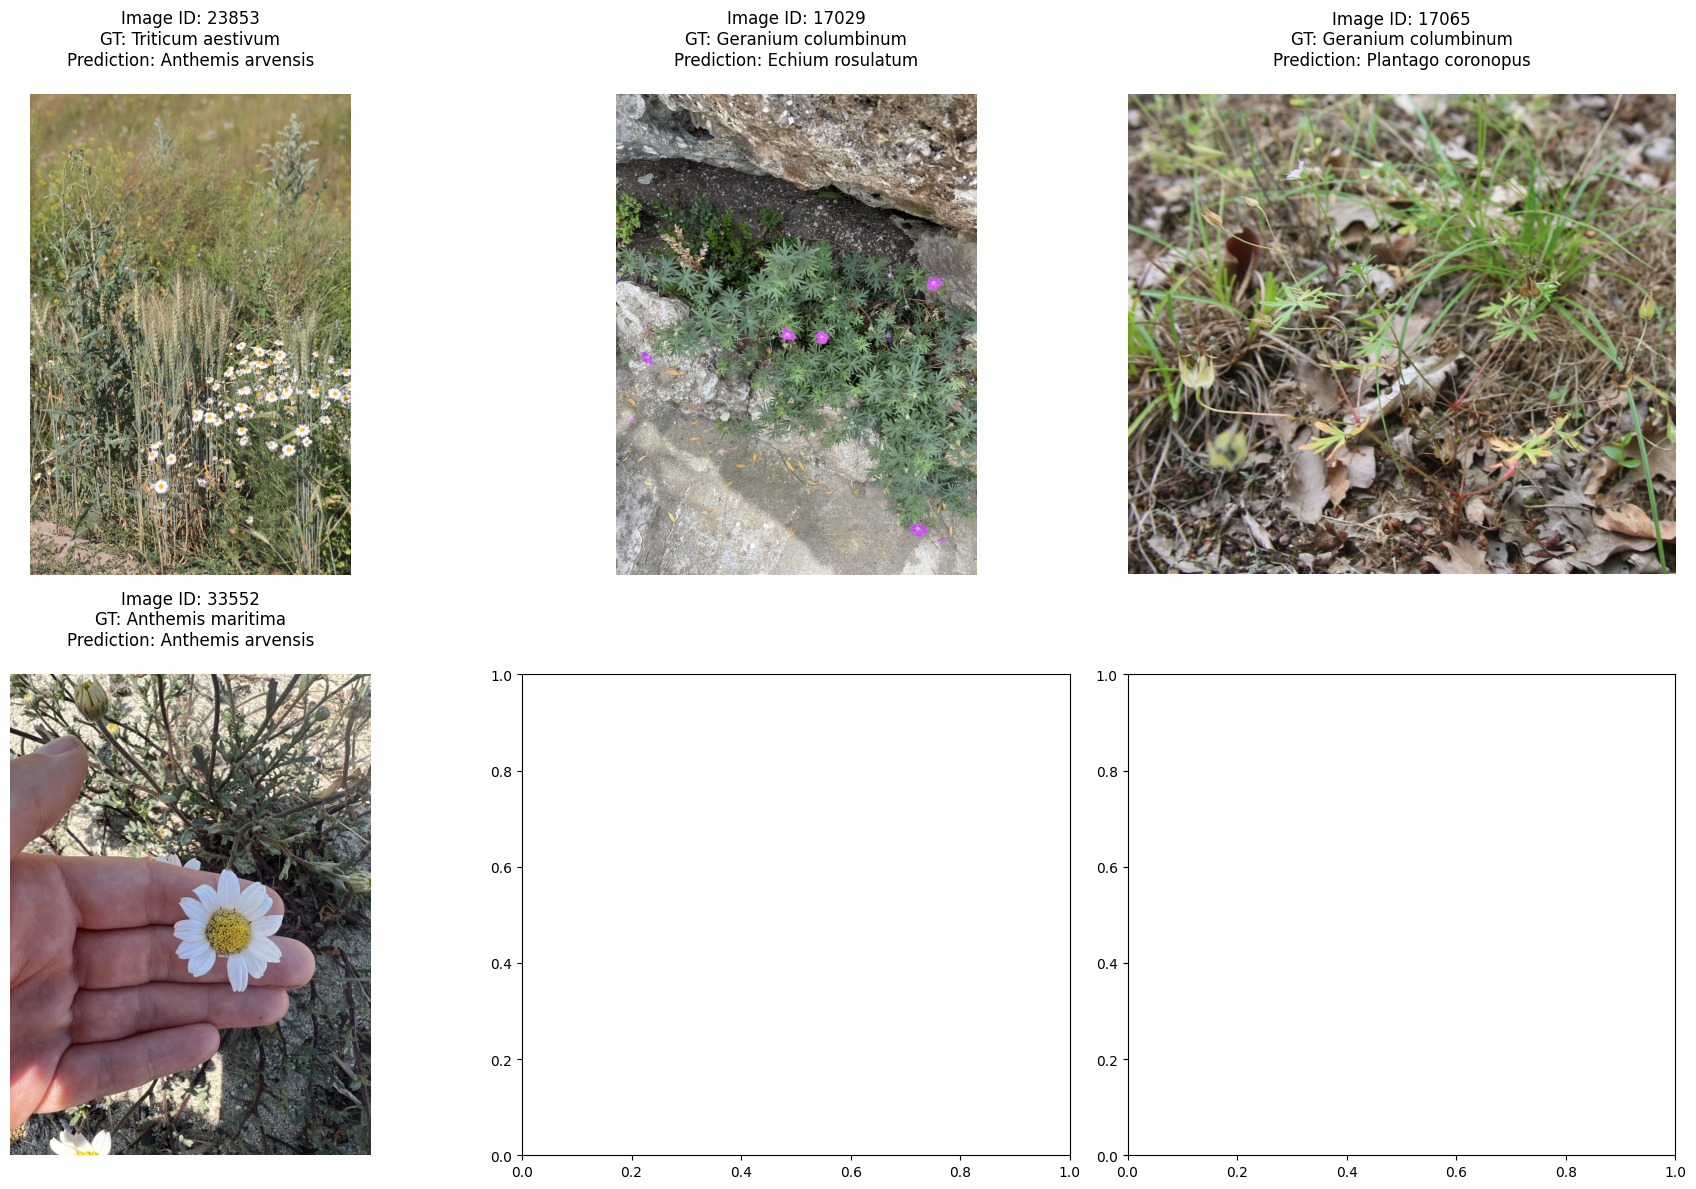

In [54]:
plot_random_predictions(eval_df,missclassified=True)

## 5. Write a report

Please write a short and concise report (6 pages at most), or make few slides to present the results. Cover the following points:
* Dataset description, findings and plots from the data exploration part
* Model selected
* Metrics of the model and error analysis
* Bonus parts (if applicable)

In your final report, please make sure to address the following questions:

1. What patterns did you find during the data exploration phase?
2. How can we address the class imbalance during training?
3. What data augmentation techniques should be used for this particular dataset
4. What metrics are good indicators that our model is performing well for this specific task?
5. Did you find any patterns in the errors made by the model during the validation? 
6. In the wild, it is rare that we are able to neatly separate individual plant species into single images, how would you change your model to be used as a multi-label classifier to be able to predict multiple species per image, and what kind of data would you need?
7. There are around 380,000 species of plant, other than with a CNN, how else could you use deep learning to identify them, and what kind of data would you need?

When you are done with the code and the report, please send the update notebook and the pdf/slides at the indicated email. 

🍀 Good luck! 